In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 

path = 'smoke_detection_iot.csv'

data = pd.read_csv(path)

Y_df = data['Fire Alarm']
X_df = data.drop(['Fire Alarm'], axis=1)

X = X_df.values
Y = Y_df.values

error_chance = 0.3
error_value = np.nan

# Introduce sensor errors
X_error = X.copy()
for datapoint in X_error:
    is_error = random.random() < error_chance
    if is_error:
        num_errored_features = random.randint(1, X.shape[1])
        errored_features = random.sample(range(X.shape[1]), num_errored_features)
        
        for feature_idx in errored_features:
            datapoint[feature_idx] = error_value  # Set the selected features to -500
        

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train_error, X_test_error, Y_train_error, Y_test_error = train_test_split(X_error, Y, test_size=0.2, random_state=0)

imputer = SimpleImputer(strategy='mean')
X_train_error = imputer.fit_transform(X_train_error)
X_test_error = imputer.transform(X_test_error)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_error = scaler.fit_transform(X_train_error)
X_test_error = scaler.transform(X_test_error)


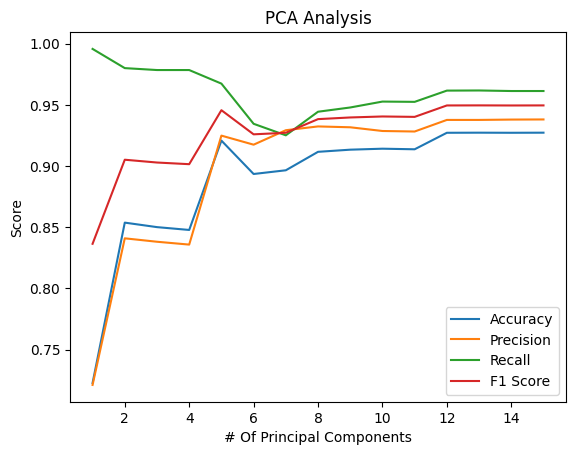

Max precision at K = 15; 0.9380879457449136
Max accuracy at K = 13; 0.9272712757464474
Max recall at K = 1; 0.9957403878488958
Max F1 Score at K = 13; 0.9495877372585911


In [32]:
K = X_train.shape[1]
datasets = np.zeros(K+1, dtype=object)
results = np.zeros((K, Y_test.shape[0]))
accuracy_hist = np.zeros(K)
precision_hist = np.zeros(K)
recall_hist = np.zeros(K)
f1_hist = np.zeros(K)

for k in range(1,K+1):
    extraction = PCA(n_components=k)  
    X_train_pca = extraction.fit_transform(X_train_error)
    X_test_pca = extraction.transform(X_test_error)
    
    datasets[k-1] = (X_train_pca, X_test_pca)
    
    error_model = LogisticRegression().fit(X_train_pca, Y_train)
    
    Y_pred = error_model.predict(X_test_pca)
    
    accuracy_hist[k-1] = accuracy_score(Y_test, Y_pred)
    precision_hist[k-1] = precision_score(Y_test, Y_pred)
    recall_hist[k-1] = recall_score(Y_test, Y_pred)
    f1_hist[k-1] = f1_score(Y_test, Y_pred)
    results[k-1] = Y_pred
    
K = range(1,k+1)
plt.title("PCA Analysis")
plt.xlabel("# Of Principal Components")
plt.ylabel("Score")
plt.plot(K,accuracy_hist, label='Accuracy')
plt.plot(K,precision_hist, label = 'Precision')
plt.plot(K,recall_hist, label = 'Recall')
plt.plot(K,f1_hist, label = 'F1 Score')

plt.legend()
plt.show()
print(f'Max precision at K = {np.argmax(precision_hist)+1}; {max(precision_hist)}')
print(f"Max accuracy at K = {np.argmax(accuracy_hist)+1}; {max(accuracy_hist)}")
print(f"Max recall at K = {np.argmax(recall_hist)+1}; {max(recall_hist)}")
print(f"Max F1 Score at K = {np.argmax(f1_hist)+1}; {max(f1_hist)}")
    
    




In [33]:
import torch
from torch import nn

class AlarmNet(nn.Module):
    def __init__(self, num_features, activation=nn.ReLU, hidden_layers = [64, 32, 16],):
        super(AlarmNet, self).__init__()
        stack_list = [nn.Linear(num_features, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  # Use extend instead of assignment
        
        stack_list.extend([nn.Linear(hidden_layers[-1], 1), nn.Sigmoid()])  # Use extend instead of assignment
        self.stack = nn.Sequential(*stack_list)
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        return self.forward(x).round()
    def train(self, epochs, X_train, X_test, Y_train, Y_test, alpha, loss_fn=nn.BCELoss()):
        optimizer = torch.optim.Adam(self.parameters(), lr=alpha)

        for epoch in range(epochs):
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred, Y_train)
            loss.backward()
            optimizer.step()
            if epoch % 500 == 0:
                print(f'Epoch {epoch} Loss: {loss.item()}')
        Y_pred = self.predict(X_test)
        self.last_pred = Y_pred
        self.last_test = Y_test
        return [Y_test,Y_pred]
    
    def get_results(self, Y_test=None, Y_pred=None):
        if Y_test is None:
            Y_test = self.last_test
        if Y_pred is None:
            Y_pred = self.last_pred
        Y_test = Y_test.cpu().detach().numpy()
        Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred),
            'recall': recall_score(Y_test, Y_pred),
            'f1': f1_score(Y_test, Y_pred),
            'confusion_matrix': confusion_matrix(Y_test, Y_pred),
            'classification_report': classification_report(Y_test, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            results = self.last_results
        for key, value in results.items():
            if key != 'confusion_matrix':
                print(f'{key.capitalize()}: {value}')
            else:
                print(f'{key.capitalize()}:\n{value}')
    
    def train_and_print(self, epochs, X_train, X_test, Y_train, Y_test, alpha):
        Y_pred = self.train(epochs, X_train, X_test, Y_train, Y_test, alpha).cpu().detach().numpy().round().astype(int)
        self.print_results(Y_test, Y_pred)
        


# NO ERROR TRAINING

In [34]:
alpha = 1e-2
epochs = 3000
device = 'cuda'
no_error_model = AlarmNet(
    num_features=X_train.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)

X_train_device = torch.tensor(X_train).float().to(device)
X_test_device = torch.tensor(X_test).float().to(device)
Y_train_device = torch.tensor(Y_train).float().view(-1, 1).to(device)
Y_test_device = torch.tensor(Y_test).float().view(-1, 1).to(device)
no_error_model.train(epochs, X_train_device, X_test_device, Y_train_device, Y_test_device, alpha)

Epoch 0 Loss: 0.685544490814209
Epoch 500 Loss: 0.0008353836019523442
Epoch 1000 Loss: 0.0003713224141392857
Epoch 1500 Loss: 0.00022153466125018895
Epoch 2000 Loss: 0.0001641880808165297
Epoch 2500 Loss: 0.00012377119855955243


[tensor([[0.],
         [1.],
         [1.],
         ...,
         [1.],
         [0.],
         [0.]], device='cuda:0'),
 tensor([[0.],
         [1.],
         [1.],
         ...,
         [1.],
         [0.],
         [0.]], device='cuda:0', grad_fn=<RoundBackward0>)]

In [35]:
no_error_results = no_error_model.get_results()
no_error_model.print_results()

Accuracy: 0.9997604981638193
Precision: 0.9998878923766816
Recall: 0.9997758098867839
F1: 0.9998318479905834
Confusion_matrix:
[[3604    1]
 [   2 8919]]
Classification_report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3605
         1.0       1.00      1.00      1.00      8921

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



# ERROR TRAINING WITH BCE

In [36]:

device = 'cuda'
error_model = AlarmNet(
    num_features=X_train_error.shape[1],
    activation=nn.Sigmoid,
    hidden_layers=[64, 32, 16]
).to(device)

X_train_device = torch.tensor(X_train_error).float().to(device)
X_test_device = torch.tensor(X_test_error).float().to(device)
Y_train_device = torch.tensor(Y_train).float().view(-1, 1).to(device)
Y_test_device = torch.tensor(Y_test).float().view(-1, 1).to(device)

alpha = 1e-1
epochs = 5000
error_model.train(
    epochs,
    X_train_device,
    X_test_device,
    Y_train_device,
    Y_test_device,
    alpha,
)
bce_error_results = error_model.get_results()
error_model.print_results()


Epoch 0 Loss: 0.608791708946228
Epoch 500 Loss: 0.04262205958366394
Epoch 1000 Loss: 0.03716694936156273
Epoch 1500 Loss: 0.03293777257204056
Epoch 2000 Loss: 0.03034963272511959
Epoch 2500 Loss: 0.028677362948656082
Epoch 3000 Loss: 0.02765483595430851
Epoch 3500 Loss: 0.03146257624030113
Epoch 4000 Loss: 0.027591388672590256
Epoch 4500 Loss: 0.029620185494422913
Accuracy: 0.9751716429825962
Precision: 0.9781208351843625
Recall: 0.9872211635466875
F1: 0.982649930264993
Confusion_matrix:
[[3408  197]
 [ 114 8807]]
Classification_report:               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3605
         1.0       0.98      0.99      0.98      8921

    accuracy                           0.98     12526
   macro avg       0.97      0.97      0.97     12526
weighted avg       0.98      0.98      0.98     12526



In [37]:
def compare_results(results1, results2):
    

    comparisons = {
        'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
        'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
        'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
        'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
    }
    for key, value in comparisons.items():
        print(f'{key}: {value} %')
        
    return

In [38]:
compare_results(bce_error_results, no_error_results)


accuracy: -2.521489971346711 %
precision: -2.2253955144730444 %
recall: -1.271715680708527 %
f1: -1.748528870394051 %


In [39]:
mse_model = AlarmNet(
    num_features=X_train_error.shape[1],
    activation=nn.Sigmoid,
    hidden_layers=[64, 32, 16]
).to(device)


mse_model.train(
    epochs,
    X_train_device,
    X_test_device,
    Y_train_device,
    Y_test_device,
    alpha,
    loss_fn=nn.MSELoss()
)
print('\n')
mse_results = mse_model.get_results()
mse_model.print_results()

compare_results(mse_results, bce_error_results)

Epoch 0 Loss: 0.24278317391872406
Epoch 500 Loss: 0.017244314774870872
Epoch 1000 Loss: 0.012274527922272682
Epoch 1500 Loss: 0.010623594745993614
Epoch 2000 Loss: 0.00998715776950121
Epoch 2500 Loss: 0.009449506178498268
Epoch 3000 Loss: 0.009029239416122437
Epoch 3500 Loss: 0.011332479305565357
Epoch 4000 Loss: 0.008770924061536789
Epoch 4500 Loss: 0.00850425660610199


Accuracy: 0.9763691521635
Precision: 0.9767827529021559
Recall: 0.9903598251317117
F1: 0.9835244350439719
Confusion_matrix:
[[3395  210]
 [  86 8835]]
Classification_report:               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      3605
         1.0       0.98      0.99      0.98      8921

    accuracy                           0.98     12526
   macro avg       0.98      0.97      0.97     12526
weighted avg       0.98      0.98      0.98     12526

accuracy: 0.12264922322159212 %
precision: -0.13698872940078421 %
recall: 0.3169213355970655 %
f1: 0.08891540950274222 %


In [ ]:
class KldivAlarmNet(AlarmNet):
    def __init__(self, *args, **kwargs):
        super(KldivAlarmNet, self).__init__(*args, **kwargs)
    def predict(self, x):
        logits = super().forward(x)
        return torch.argmax(logits, dim=1)
    def train()

In [41]:
kldiv_model = AlarmNet(
    num_features=X_train_error.shape[1],
    activation=nn.Sigmoid,
    hidden_layers=[64, 32, 16]
).to(device)

kldiv_model.train(
    epochs,
    X_train_device,
    X_test_device,
    Y_train_device,
    Y_test_device,
    alpha,
    loss_fn=nn.KLDivLoss(reduction='batchmean')
)

print('\n')
kldiv_results = kldiv_model.get_results()
kldiv_model.print_results()

print('\n')
compare_results(kldiv_results, mse_results)

Epoch 0 Loss: -0.4071097671985626
Epoch 500 Loss: -0.7152304649353027
Epoch 1000 Loss: -0.7152309417724609
Epoch 1500 Loss: -0.7152313590049744
Epoch 2000 Loss: -0.715231716632843
Epoch 2500 Loss: -0.715231716632843
Epoch 3000 Loss: -0.7152321934700012
Epoch 3500 Loss: -0.7152321934700012
Epoch 4000 Loss: -0.715232253074646
Epoch 4500 Loss: -0.715232253074646


Accuracy: 0.7121986268561392
Precision: 0.7121986268561392
Recall: 1.0
F1: 0.8319112230148739
Confusion_matrix:
[[   0 3605]
 [   0 8921]]
Classification_report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3605
         1.0       0.71      1.00      0.83      8921

    accuracy                           0.71     12526
   macro avg       0.36      0.50      0.42     12526
weighted avg       0.51      0.71      0.59     12526



accuracy: -37.09225423158839 %
precision: -37.15032802210968 %
recall: 0.9640174868288276 %
f1: -18.224686461092176 %


/home/jaskin/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jaskin/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jaskin/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
